In [4]:
from math import floor
import math 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [27]:

"En este apartado se obtiene los bbordes por medio de Laplace "
# función para aplicar una convolución 2D a una imagen
def convolucion_2d(imagen, kernel):
    alto, ancho = imagen.shape
    k_alto, k_ancho = kernel.shape
        # cálculo del borde para evitar desbordamiento
    bordeH = int((k_alto-1)/2)
    bordeW = int((k_ancho-1)/2)
    
    imagen_ampliada = np.zeros((alto + bordeH*2, ancho + bordeW*2))
    imagen_ampliada[bordeH:-bordeH, bordeW:-bordeW] = imagen
    resultado = np.zeros_like(imagen)
    
    # aplicación del kernel a cada píxel de la imagen
    for i in range(bordeH, alto+bordeH):
        for j in range(bordeW, ancho+bordeW):
            trozo = imagen_ampliada[i-bordeH:i+bordeH+1, j-bordeW:j+bordeW+1]
            resultado[i-bordeH, j-bordeW] = (trozo * kernel).sum()
    
    return resultado

# función para aplicar una umbralización a una imagen
def umbralizacion(imagen, umbral):
    resultado = np.zeros_like(imagen)
    resultado[imagen > umbral] = 255

    return resultado

def thresholdOtsu(img): #min(weightB*VarianceB + weightF*VarianceF)
    #Histogram
    hist = np.zeros(256)
    for row in range(img.shape[0]):
        for column in range(img.shape[1]):
            hist[img[row][column][0]] += 1
    
    pixelesInImg = img.shape[0]*img.shape[1]
    WCVList = []

    #Algorithm
    for threshold in range(len(hist)):
        #b where hist < threshold
        b = hist[:threshold]
        #Weight b
        w_b = sum(b)/(pixelesInImg)
        #Mean b
        m = 0
        for i in range(threshold):
            m += (i*hist[i])
        if(sum(b)==0):
            m_b = 0
        else:
            m_b = m/sum(b)
        #Variance b
        v = 0
        for i in range(threshold):
            v += ((i-m_b)**2) * hist[i]
        if(sum(b)==0):
            v_b = 0
        else:
            v_b = v/sum(b)

        #f where hist >= threshold
        f = hist[threshold:]
        #Weight f
        w_f = sum(f)/(pixelesInImg)
        #Mean f
        m = 0
        for i in range(threshold, len(hist)):
            m += (i*hist[i])
        m_f = m/sum(f)
        #Variance f
        v = 0
        for i in range(threshold, len(hist)):
            v += ((i-m_f)**2) * hist[i]
        v_f = v/sum(f)
        #Within_class_variance
        WCV = (w_b*v_b)+(w_f*v_f)
        WCVList.append(WCV)
        
    t = WCVList.index(min(WCVList))
    
    return t #The rigth threshold

# definición del kernel para la convolución
kernel = np.array([[-1, -1, -1], 
                   [-1,  8, -1], 
                   [-1, -1, -1]])

def factorial(x):
    return 1 if x == 0 else x * factorial(x - 1)

def triangle(n):
    return [[factorial(i) / (factorial(j) * factorial(i - j)) for j in range(i + 1)] for i in range(n)]


def kernelGauss(n):
    h = triangle(n)[n-1]
    v = np.vstack(h)
    #print(h*v)
    return h*v

def kerLaplace():
    return np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])

'''def KerGauss():
    return np.array([[1,2,4,2,1],
                    [2,4,8,2,4],
                    [1,2,4,4,1]])'''

def kerGauss():
    return np.ones((5,5))

def kernelGaussX(n):
    kernelGaussX = kernelGauss(n)
    kernelGaussX[:,0] = kernelGaussX[:,0] * -1
    kernelGaussX[:,1] = kernelGaussX[:,1] * 0
    return kernelGaussX

def kernelGaussY(n):
    kernelGaussY = kernelGauss(n)
    kernelGaussY[0, :] = kernelGaussY[0, :] * -1
    kernelGaussY[1, :] = kernelGaussY[1, :] * 0
    return kernelGaussY

In [6]:
'''Esta permite obtener el umbral promedio de cada imagen '''
def thresholdOtsuGris(img):
    img = img.astype(np.uint8)
    # Calcular el histograma
    hist = np.zeros(256, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1
    
    # Total de píxeles en la imagen
    total_pixels = img.shape[0] * img.shape[1]
    
    # Inicializar variables
    sum_intensity = 0
    sum_background = 0
    weight_background = 0
    best_threshold = 0
    max_between_variance = 0
    
    # Calcular el umbral óptimo de Otsu
    for threshold in range(256):
        weight_background += hist[threshold]
        weight_foreground = total_pixels - weight_background
        
        if weight_background == 0 or weight_foreground == 0:
            continue
        
        sum_intensity += threshold * hist[threshold]
        mean_background = sum_intensity / weight_background
        mean_foreground = (sum_intensity - mean_background * weight_background) / weight_foreground
        
        between_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
        
        if between_variance > max_between_variance:
            max_between_variance = between_variance
            best_threshold = threshold
    
    return best_threshold


In [45]:
def laplace(imagen):
    umbral = thresholdOtsu (np.array(imagen))
    matrixRes=(convolucion_2d(imagen.mean(axis=2),kerLaplace()))
    matrixRes = umbralizacion(matrixRes, umbral)
    return matrixRes.astype(np.uint8)

def suavizado (imagen):
    matrixRes = convolucion_2d(imagen,kerGauss())
    return matrixRes

def sobel(imagen, n):
    umbral = thresholdOtsu(np.array(imagen))
    matrixRes = np.zeros((imagen.shape[0], imagen.shape[1]))
    matrixResX=(convolucion_2d(imagen.mean(axis=2),kernelGaussX(n) ))
    matrixResY=(convolucion_2d(imagen.mean(axis=2),kernelGaussX(n) ))
    

    for x in range(imagen.shape[0]):
        for y in range(imagen.shape[1]):
            matrixRes[x][y] = math.sqrt(matrixResX[x][y]**2 + matrixResY[x][y] **2)
    #muestra de la capa X y la capa Y
    matrixRes = umbralizacion(matrixRes, umbral)
    
    return matrixRes.astype(np.uint8)

def perfilado(imagen,n,a):
    umbral = thresholdOtsu(np.array(imagen))
    kernelPerf =np.array([[0,  -a,       0],
                          [-a, (n*a)+1, -a], 
                          [0,  -a,       0]])  
    matrixRes = convolucion_2d(imagen.mean(axis=2), kernelPerf)
    matrixRes = umbralizacion(matrixRes, 255-umbral)
    
    return matrixRes.astype(np.uint8)


In [38]:
''''Recorte de la imagen por cada uno de las capas de laimagen, el recorte se hace al obtener los puntosmas luminosos de ancho  largo'''
def recorte(imagen,umbral):
    #umbral = thresholdOtsu(np.array(imagen))
    minAncho = 1000
    maxAncho = 0
    minAlto = 1000
    maxAlto = 0
    '''Se trata de evitar que se tomen puntos que se enencuetren fuera del cerebro'''
    limite = int(umbral *1.05)
    print(limite)
    for i in range(0, imagen.shape[0]):
        for j in range(0, imagen.shape[1]):
            if np.all((imagen[i][j] >= umbral) & (limite>=imagen[i][j]) ):
                if(i < minAncho):
                    minAncho = i
                if(i > maxAncho):
                    maxAncho = i
                if(j < minAlto):
                    minAlto = j
                if(j > maxAlto):
                    maxAlto = j

    #imprimos los valores maximas y minimos de ancho y alto
    '''print ("valores de la imagen original")
    print("minAncho: ", minAncho)
    print("maxAncho: ", maxAncho)
    print("minAlto: ", minAlto)
    print("maxAlto: ", maxAlto)'''

    #recortamos la imagen
    imagen = imagen[minAncho:maxAncho, minAlto:maxAlto]

    return imagen 

'''Es la misma función pero en este caso el recorte se hace para imagenes en escala de grises'''
def recorteGris(imagen,umbral):
    #umbral = thresholdOtsu(np.array(imagen))
    minAncho = 1000
    maxAncho = 0
    minAlto = 1000
    maxAlto = 0
    limite = int(umbral *1.05)
    for i in range(0, imagen.shape[0]):
        for j in range(0, imagen.shape[1]):
            if  np.all((imagen[i][j] >= umbral) & (limite>=imagen[i][j])  ):
                if(i < minAncho):
                    minAncho = i
                if(i > maxAncho):
                    maxAncho = i
                if(j < minAlto):
                    minAlto = j
                if(j > maxAlto):
                    maxAlto = j

    #imprimos los valores maximas y minimos de ancho y alto
    '''print ("valores de la imagen original")
    print("minAncho: ", minAncho)
    print("maxAncho: ", maxAncho)
    print("minAlto: ", minAlto)
    print("maxAlto: ", maxAlto)'''

    #recortamos la imagen
    imagen = imagen[minAncho:maxAncho, minAlto:maxAlto]

    return imagen 

In [36]:

#Lectura de imagen
im_path='yes/Y1.jpg'

#Arreglo de n*m (de la imagen)
image=np.array(Image.open(im_path))

#Funcion de interpolacion bilineal (imagen, ancho, alto)
def BiLinear_interpolation(img,dstH,dstW):
    
    #Crea el arreglo con las dimensiones dadas
    scrH,scrW,_=img.shape 
    #print(img.shape)
    img=np.pad(img,((0,1),(0,1),(0,0)),'constant')
    
    #Llenar la matriz de 0's
    retimg=np.zeros((dstH,dstW,3),dtype=np.uint8)
    
    #Recorrido en ancho y alto 
    for i in range(dstH):
        for j in range(dstW):
            
            #Interpolacion en X
            scrx=(i+1)*(scrH/dstH)-1
            
            #Interpolacion en Y
            scry=(j+1)*(scrW/dstW)-1
            
            #Funcion piso
            x=math.floor(scrx)
            y=math.floor(scry)
            
            #Asignacion de los valores con funcion piso
            u=scrx-x
            v=scry-y
            
            #Llenar los valores de la nueva imagen redimensionada con el recorrido de for anidados
            retimg[i,j]=(1-u)*(1-v)*img[x,y]+u*(1-v)*img[x+1,y]+(1-u)*v*img[x,y+1]+u*v*img[x+1,y+1]
    return retimg

#Llamado de funcion al doble de tamaño
#image2=BiLinear_interpolation(image,500,500)

#Conversion a imagen
#image2=Image.fromarray(image2.astype('uint8')).convert('RGB')

#Guardar la imagen
#image2.save('BILINEAL.png')

126
255


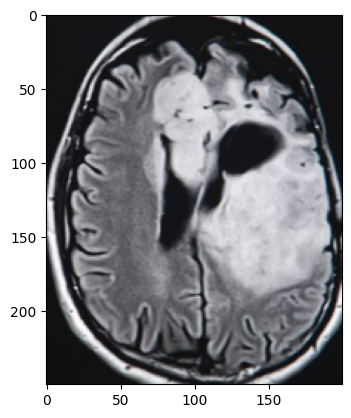

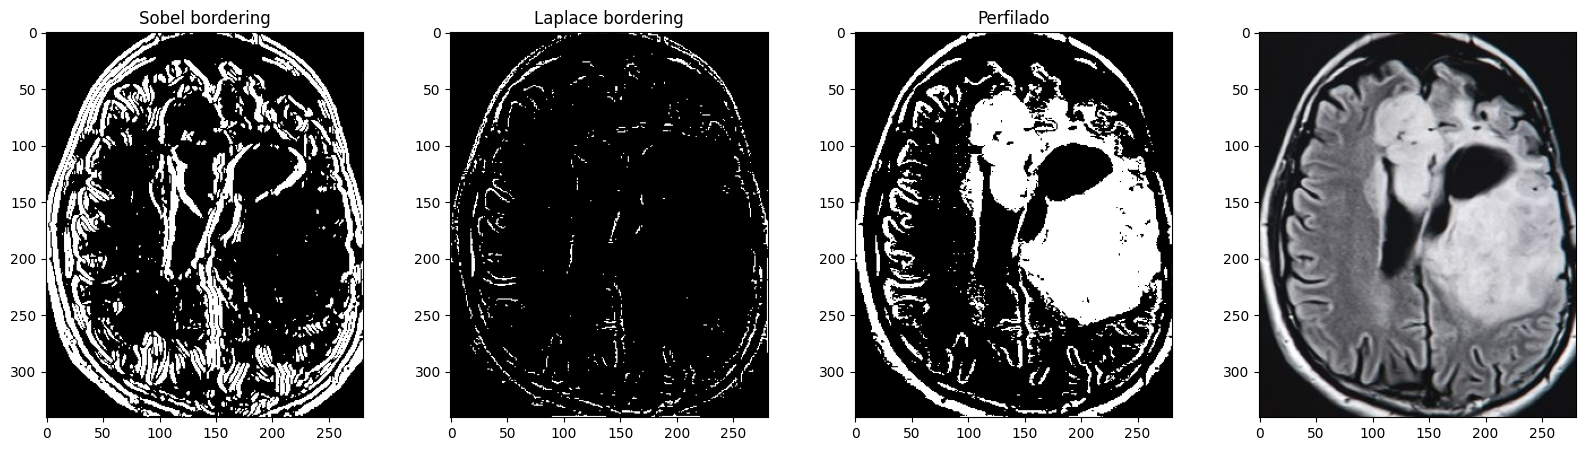

In [48]:
# lectura de la imagen
imagen = Image.open("yes/Y16.jpg")
plt.show()
if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
    imagen = imagen.convert('RGB')
#imagen = recorte(np.array(imagen), thresholdOtsuGris(np.array(imagen))).astype(np.uint8)
imagen = recorte(np.array(imagen),120)
print(thresholdOtsuGris(np.array(imagen)))
image2=BiLinear_interpolation(imagen,250,200)

#imagen = recorte (np.array(imagen),thresholdOtsuGris(np.array(imagen)))

#plt.imshow(imagen,cmap="gray")
#plt.show()
image2=Image.fromarray(image2.astype('uint8')).convert('RGB')
#Guardar la imagen
#image2.save('BILINEAL.png')


plt.imshow(image2)
plt.imsave('C:\\ProyectoImgIa\\ProyectoFinalTumor\\yes_nuevo\\Y18.jpg', image2, cmap='gray')
plt.show()

bordeLA = laplace(imagen)
bordeSo = sobel(imagen,3)
perfil = perfilado(imagen,4,1)

fig, axs = plt.subplots(1,4,figsize=(20, 5))
axs[0].imshow(bordeSo, cmap ="gray")
axs[0].set_title("Sobel bordering")
axs[1].imshow(bordeLA, cmap ="gray")
axs[1].set_title("Laplace bordering")
axs[2].imshow(perfil, cmap ="gray")
axs[2].set_title("Perfilado")
axs[3].imshow(imagen)
plt.show()

In [11]:
#Elimiinar el ruido de la imagen

#Expande las areas blancas
def dilatacion(A,B):
    m, n = A.shape
    p, q = B.shape
    C = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            for k in range(p):
                for l in range(q):
                    if B[k, l] == 1 and i+k-p//2 >= 0 and i+k-p//2 < m and j+l-q//2 >= 0 and j+l-q//2 < n:
                        C[i, j] = np.max([C[i, j], np.max(A[i+k-p//2, j+l-q//2])])
                        

    return C

#Se expaden las areas negras 
def erosion(imagen, kernel):
    altura, ancho = imagen.shape
    m, n = kernel.shape
    resultado = np.zeros((altura, ancho))
    
    for i in range(m//2, altura-m//2):
        for j in range(n//2, ancho-n//2):
            # Realizar la operación de erosión
            if (imagen[i-m//2:i+m//2+1, j-n//2:j+n//2+1] * kernel).min() >= 1:
                resultado[i, j] = 1
    
    return resultado

def abierto(A, B):
    C = erosion(A, B)
    D = dilatacion(C, B)
    return D

def cerrado(A, B):
    C = dilatacion(A, B)
    D = erosion(C, B)
    return D


In [12]:
'''bordeSo = sobel(imagen,3)
kernel = np.ones((3,3),np.uint8)
prueba1 = suavizado(bordeLA)
plt.imshow(prueba1, cmap="gray")
plt.show()'''


'bordeSo = sobel(imagen,3)\nkernel = np.ones((3,3),np.uint8)\nprueba1 = suavizado(bordeLA)\nplt.imshow(prueba1, cmap="gray")\nplt.show()'

In [13]:
'''kernel = np.ones((5,5),np.uint8)
kernel2 = np.ones((3,3), np.uint8)
prueba = erosion(erosion(prueba1,kernel),kernel)
prueba2 = erosion(dilatacion(prueba,kernel),kernel2)
plt.imshow(prueba2, cmap="gray")
plt.show()'''


'kernel = np.ones((5,5),np.uint8)\nkernel2 = np.ones((3,3), np.uint8)\nprueba = erosion(erosion(prueba1,kernel),kernel)\nprueba2 = erosion(dilatacion(prueba,kernel),kernel2)\nplt.imshow(prueba2, cmap="gray")\nplt.show()'

In [14]:
'''prueba3 = recorteGris(prueba2,thresholdOtsuGris(prueba2))

plt.imshow(prueba3, cmap="gray")
plt.show()'''


'prueba3 = recorteGris(prueba2,thresholdOtsuGris(prueba2))\n\nplt.imshow(prueba3, cmap="gray")\nplt.show()'

yes/Y1.jpg
126


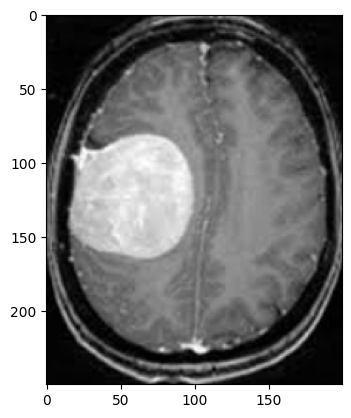

yes/Y10.jpg
126


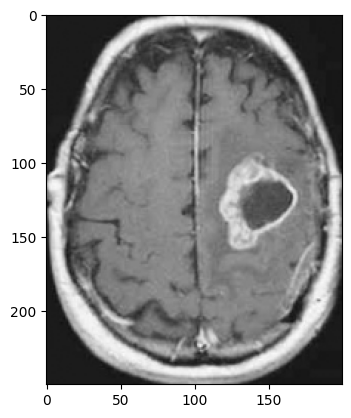

yes/Y101.jpg
126


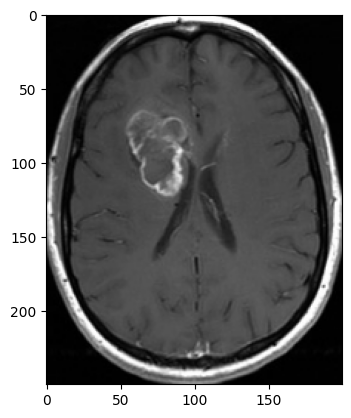

yes/Y102.jpg
126


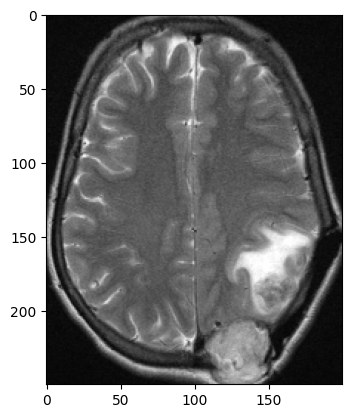

yes/Y103.jpg
126


KeyboardInterrupt: 

In [52]:
# Ruta de la carpeta que contiene las imágenes
def abrirArchivo():
    ruta_carpeta = 'C:\ProyectoImgIa\ProyectoFinalTumor\yes'

    # Obtener la lista de archivos en la carpeta
    archivos = os.listdir(ruta_carpeta)

    # Iterar sobre cada archivo en la carpeta
    for archivo in archivos:
        # Comprobar si el archivo es una imagen
        if archivo.endswith('.jpg') :
            # Ruta completa de la imagen
            ruta_imagen = os.path.join('yes/', archivo)

            # Abrir la imagen utilizando PIL/Pillow
            imagen = Image.open(ruta_imagen)
            print(ruta_imagen)
            if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
                imagen = imagen.convert('RGB')
            #imagen = recorte(np.array(imagen), thresholdOtsuGris(np.array(imagen))).astype(np.uint8)
            imagen = recorte(np.array(imagen),120)
            image2 = BiLinear_interpolation(imagen,250,200)
            plt.imshow(image2,cmap="gray")
            plt.show()

            # Realizar operaciones con la imagen


            # Por ejemplo, mostrar la imagen
            #imagen.show()
            del image2
            # Cerrar la imagen
            #imagen.close()

abrirArchivo()

In [57]:
from os import listdir
from os.path import isfile, join

dir_to_search = 'C:\\ProyectoImgIa\\ProyectoFinalTumor\\yes'
contador = 0
for file in listdir(dir_to_search):
    if isfile(join(dir_to_search, file)):
        print(file)
        contador = contador +1

print(contador)


Y1.jpg
Y10.jpg
Y100.JPG
Y101.jpg
Y102.jpg
Y103.jpg
Y105.jpg
Y107.jpg
Y108.jpg
Y109.JPG
Y11.jpg
Y111.JPG
Y112.JPG
Y113.JPG
Y114.JPG
Y115.JPG
Y116.JPG
Y117.JPG
Y12.jpg
Y120.JPG
Y13.jpg
Y14.jpg
Y146.JPG
Y148.JPG
Y153.jpg
Y154.jpg
Y155.JPG
Y156.JPG
Y157.JPG
Y158.JPG
Y159.JPG
Y16.JPG
Y160.JPG
Y161.JPG
Y162.jpg
Y163.JPG
Y164.JPG
Y165.JPG
Y166.JPG
Y167.JPG
Y168.jpg
Y169.jpg
Y17.jpg
Y170.JPG
Y18.JPG
Y180.jpg
Y181.jpg
Y182.JPG
Y183.jpg
Y184.JPG
Y185.jpg
Y186.jpg
Y187.jpg
Y188.jpg
Y19.JPG
Y192.JPG
Y193.JPG
Y194.jpg
Y195.JPG
Y2.jpg
Y20.jpg
Y21.jpg
Y22.jpg
Y23.JPG
Y24.jpg
Y242.JPG
Y243.JPG
Y244.JPG
Y245.jpg
Y246.JPG
Y247.JPG
Y248.JPG
Y249.JPG
Y25.jpg
Y250.jpg
Y251.JPG
Y252.jpg
Y253.JPG
Y254.jpg
Y255.JPG
Y256.JPG
Y257.jpg
Y258.JPG
Y259.JPG
Y26.jpg
Y27.jpg
Y28.jpg
Y29.jpg
Y3.jpg
Y30.jpg
Y31.jpg
Y32.jpg
Y33.jpg
Y34.jpg
Y35.jpg
Y36.JPG
Y37.jpg
Y38.jpg
Y4.jpg
Y40.JPG
Y41.jpg
Y42.jpg
Y44.JPG
Y45.JPG
Y46.jpg
Y47.JPG
Y49.JPG
Y50.JPG
Y51.jpg
Y52.jpg
Y53.jpg
Y54.jpg
Y55.jpg
Y56.jpg
Y58.JPG
Y6.jpg
Y60.jpg
Y6

In [64]:
import glob
def abrirArchivo():
    #ruta_carpeta = 'C:\\ProyectoImgIa\\ProyectoFinalTumor\\yes'
    carpeta_destino = 'C:\\ProyectoImgIa\\ProyectoFinalTumor\\yes_nuevo'
 
    #input_dir = Path('C:\\ProyectoImgIa\\ProyectoFinalTumor\\yes')
    #for file in input_dir.iterdir():
        #print(file, Path.isfile(file), file.endswith(".jpg"))
    dir_to_search = 'C:\\ProyectoImgIa\\ProyectoFinalTumor\\yes'
    '''file_list = []

    for file in listdir(dir_to_search):
        if isfile(join(dir_to_search, file)):
            file_list.append(file)'''
    # Obtener la lista de archivos en la carpeta
    archivos = os.listdir(dir_to_search)
    # print(archivos)

    # Crear la carpeta de destino si no existe
    os.makedirs(carpeta_destino, exist_ok=True)
    #file_list = glob.glob(dir_to_search + '/*.jpg')
    # Inicializar contador para generar nombres de archivo únicos
    contador = 1

    # Iterar sobre cada archivo en la carpeta
    for archivo in archivos:
    # Comprobar si el archivo es una imagen
            contador += 1
            #print(archivo)
            # Ruta completa del archivo de origen
            ruta_archivo_origen = os.path.join(dir_to_search, archivo)

            # Abrir la imagen utilizando PIL/Pillow
            imagen = Image.open(ruta_archivo_origen)
            if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
                imagen = imagen.convert('RGB')
            #imagen = recorte(np.array(imagen), thresholdOtsuGris(np.array(imagen))).astype(np.uint8)
            imagen = recorte(np.array(imagen),120)
            image2 = BiLinear_interpolation(imagen, 250, 200)

            # Generar el nombre único del archivo destino
            nombre_archivo_destino = f'{archivo}'
            print(nombre_archivo_destino)
            

            # Generar la ruta completa para guardar la imagen en la carpeta destino
            ruta_archivo_destino = os.path.join(carpeta_destino, nombre_archivo_destino)

            # Guardar la imagen en la carpeta destino
            plt.imsave(ruta_archivo_destino, image2, cmap='gray')

            # Cerrar la imagen original
            #imagen.close()
            del imagen
            del image2
        
            
    print(contador)


abrirArchivo()


134
Y1.jpg
134
Y10.jpg
134
Y100.JPG
134
Y101.jpg
134
Y102.jpg
134
Y103.jpg
134
Y105.jpg
134
Y107.jpg
134
Y108.jpg
134
Y109.JPG
134
Y11.jpg
134
Y111.JPG
134
Y112.JPG
134
Y113.JPG
134
Y114.JPG
134
Y115.JPG
134
Y116.JPG
134
Y117.JPG
134
Y12.jpg
134
Y120.JPG
134
Y13.jpg
134
Y14.jpg
134
Y146.JPG
134
Y148.JPG
134
Y153.jpg
134
Y154.jpg
134
Y155.JPG
134
Y156.JPG
134
Y157.JPG
134
Y158.JPG
134
Y159.JPG
134
Y16.JPG
134
Y160.JPG
134
Y161.JPG
134
Y162.jpg
134
Y163.JPG
134
Y164.JPG
134
Y165.JPG
134
Y166.JPG
134
Y167.JPG
134
Y168.jpg
134
Y169.jpg
134
Y17.jpg
134
Y170.JPG
134
Y18.JPG
134
Y180.jpg
134
Y181.jpg
134
Y182.JPG
134
Y183.jpg
134
Y184.JPG
134
Y185.jpg
134
Y186.jpg
134
Y187.jpg
134
Y188.jpg
134
Y19.JPG
134
Y192.JPG
134
Y193.JPG
134
Y194.jpg
134
Y195.JPG
134
Y2.jpg
134
Y20.jpg
134
Y21.jpg
134
Y22.jpg
134
Y23.JPG
134
Y24.jpg
134
Y242.JPG
134
Y243.JPG
134
Y244.JPG
134
Y245.jpg
134
Y246.JPG
134
Y247.JPG
134
Y248.JPG
134
Y249.JPG
134
Y25.jpg
134
Y250.jpg
134
Y251.JPG
134
Y252.jpg
134
Y253.JPG
134
Y

KeyboardInterrupt: 

In [ ]:
# Ruta de la carpeta que contiene las imágenes
def abrirArchivo():
    ruta_carpeta = 'C:\ProyectoImgIa\ProyectoFinalTumor\yes'

    # Obtener la lista de archivos en la carpeta
    archivos = os.listdir('yes/')

    # Iterar sobre cada archivo en la carpeta
    for archivo in archivos:
        # Comprobar si el archivo es una imagen
        if archivo.endswith('.jpg') :
            # Ruta completa de la imagen
            ruta_imagen = os.path.join('yes/', archivo)

            # Abrir la imagen utilizando PIL/Pillow
            imagen = Image.open(ruta_imagen)
            print(ruta_imagen)
            if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
                imagen = imagen.convert('RGB')
            #imagen = recorte(np.array(imagen), thresholdOtsuGris(np.array(imagen))).astype(np.uint8)
            bordeLA = laplace(imagen)
            bordeSo = sobel(imagen,3)
            perfil = perfilado(imagen,4,1)

            fig, axs = plt.subplots(1,3,figsize=(20, 5))
            axs[0].imshow(bordeSo, cmap ="gray")
            axs[0].set_title("Sobel bordering")
            axs[1].imshow(bordeLA, cmap ="gray")
            axs[1].set_title("Laplace bordering")
            axs[2].imshow(perfil, cmap ="gray")
            plt.show()

            
            # Realizar operaciones con la imagen


            # Por ejemplo, mostrar la imagen
            #imagen.show()
            del image2
            # Cerrar la imagen
            #imagen.close()

abrirArchivo()

yes/Y1.jpg


AttributeError: mean